<a href="https://colab.research.google.com/github/Mayar215999/data-science-project/blob/main/Tackle_Imbalanced_Data_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0

# install imbalanced-learn package
!pip install imbalanced-learn==0.8.0

# Note: If your environment doesn't support "!mamba install", use "!pip install"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [5]:
# First, let's upgrade scikit-learn to a version which should include the _print_elapsed_time function
!pip install --upgrade scikit-learn

# install imbalanced-learn package, as per user request
!pip install imbalanced-learn==0.8.0

# Now that the correct version of scikit-learn is available, we can import the libraries
# %%
## Import packages here
import pandas as pd
import numpy as np

from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from collections import Counter

In [6]:
from collections import Counter  # Remove "in google collab" from this line


In [7]:
!pip install imbalanced-learn


In [8]:
!pip install shap lime
import shap
import lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=639c5860f5ef1cdbe5a5965b6552eb810a217d6ea17d45d01a028de9fb62921b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [9]:
%matplotlib inline


In [10]:
rs = 123
# Grid search hyperparameters for a logistic regression model
def grid_search_lr(X_train, y_train):
    params_grid = {
    'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}]
    }
    lr_model = LogisticRegression(random_state=rs, max_iter=1000)
    grid_search = GridSearchCV(estimator = lr_model,
                           param_grid = params_grid,
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Grid search hyperparameters for a random forest model
def grid_search_rf(X_train, y_train):
    params_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}]
    }
    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model,
                           param_grid = params_grid,
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

In [11]:
def split_data(df):
    X = df.loc[ : , df.columns != 'Class']
    y = df['Class'].astype('int')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

Scenario: Credit Card Fraud Detection
Let's start with a credit card fraud detection scenario. The dataset contains transactions made by credit cards. As you can imagine, the majority of transactions are normal and only a very few real fraud transactions are in the dataset. Our goal is to train a classification model to recognize those fraudulent credit card transactions.

First, we load the dataset as a dataframe:

In [12]:
credit_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)

In [13]:
credit_df.head()

,V14,V17,V4,V10,V28,Class
0,0.423619,-0.210863,0.933459,0.027866,0.019308,0
1,0.986727,0.174009,-2.019905,-1.620065,-0.307753,0
2,-0.023094,-0.541985,-0.902618,-0.192212,-0.048965,0
3,-0.152111,-0.615094,1.276126,-0.026822,0.044480,0
4,-0.535807,-0.248563,4.517539,1.871441,0.120955,0


Due to confidentiality issues, the original features and other background information about each transaction is hidden, and this dataset now contains only numerical features which are the result of a PCA transformation.







Next, let's see how imbalanced this dataset is:

In [14]:
credit_df['Class'].value_counts()

,count
Class,
0,200000
1,200


<Axes: xlabel='Class'>

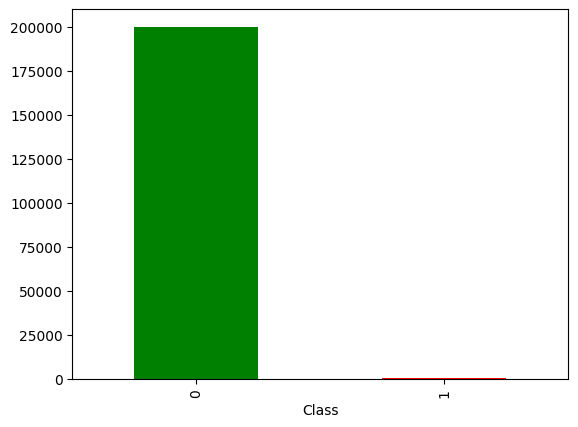

In [15]:
# Visualize the count for each class
credit_df['Class'].value_counts().plot.bar(color=['green', 'red'])

As you can see, we only have about 0.001% fraud transactions in the dataset and you can not even see it on the previous bar chart! This is an extremely imbalanced dataset

Next, we will quickly build a standard logistic regression model to see how it performs on such an imbalanced dataset.

In [16]:
# Split the training and testing dataset
X_train, X_test, y_train, y_test = split_data(credit_df)

In [17]:
# Build a simple logistic regression model
model = LogisticRegression(random_state=rs,
                              max_iter = 1000)

# Train the model
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [18]:
accuracy_score(y_test, preds)

0.9992757242757243

OK, it achieves 99% prediction accuracy on the test dataset, looks like a great model! Before concluding we have found a simple and great model to detect credit card frauds, let's try other metrics first.

More Robust Evaluation Metrics
Here are some effective robust binary classification evaluation metrics such as Precision, Recall, and Fscore, which can be defined as follows:

Precision: the percentage of accurately predicted positive instances

Recall: the percentage of successfully recognized positive instances

Fscore: can also be called F-beta score, which is a weighted average of precision and recall to evaluate the model. The weights between recall and precision are controlled by the beta parameter, the default value is 1 so the most common F-beta is F1 score

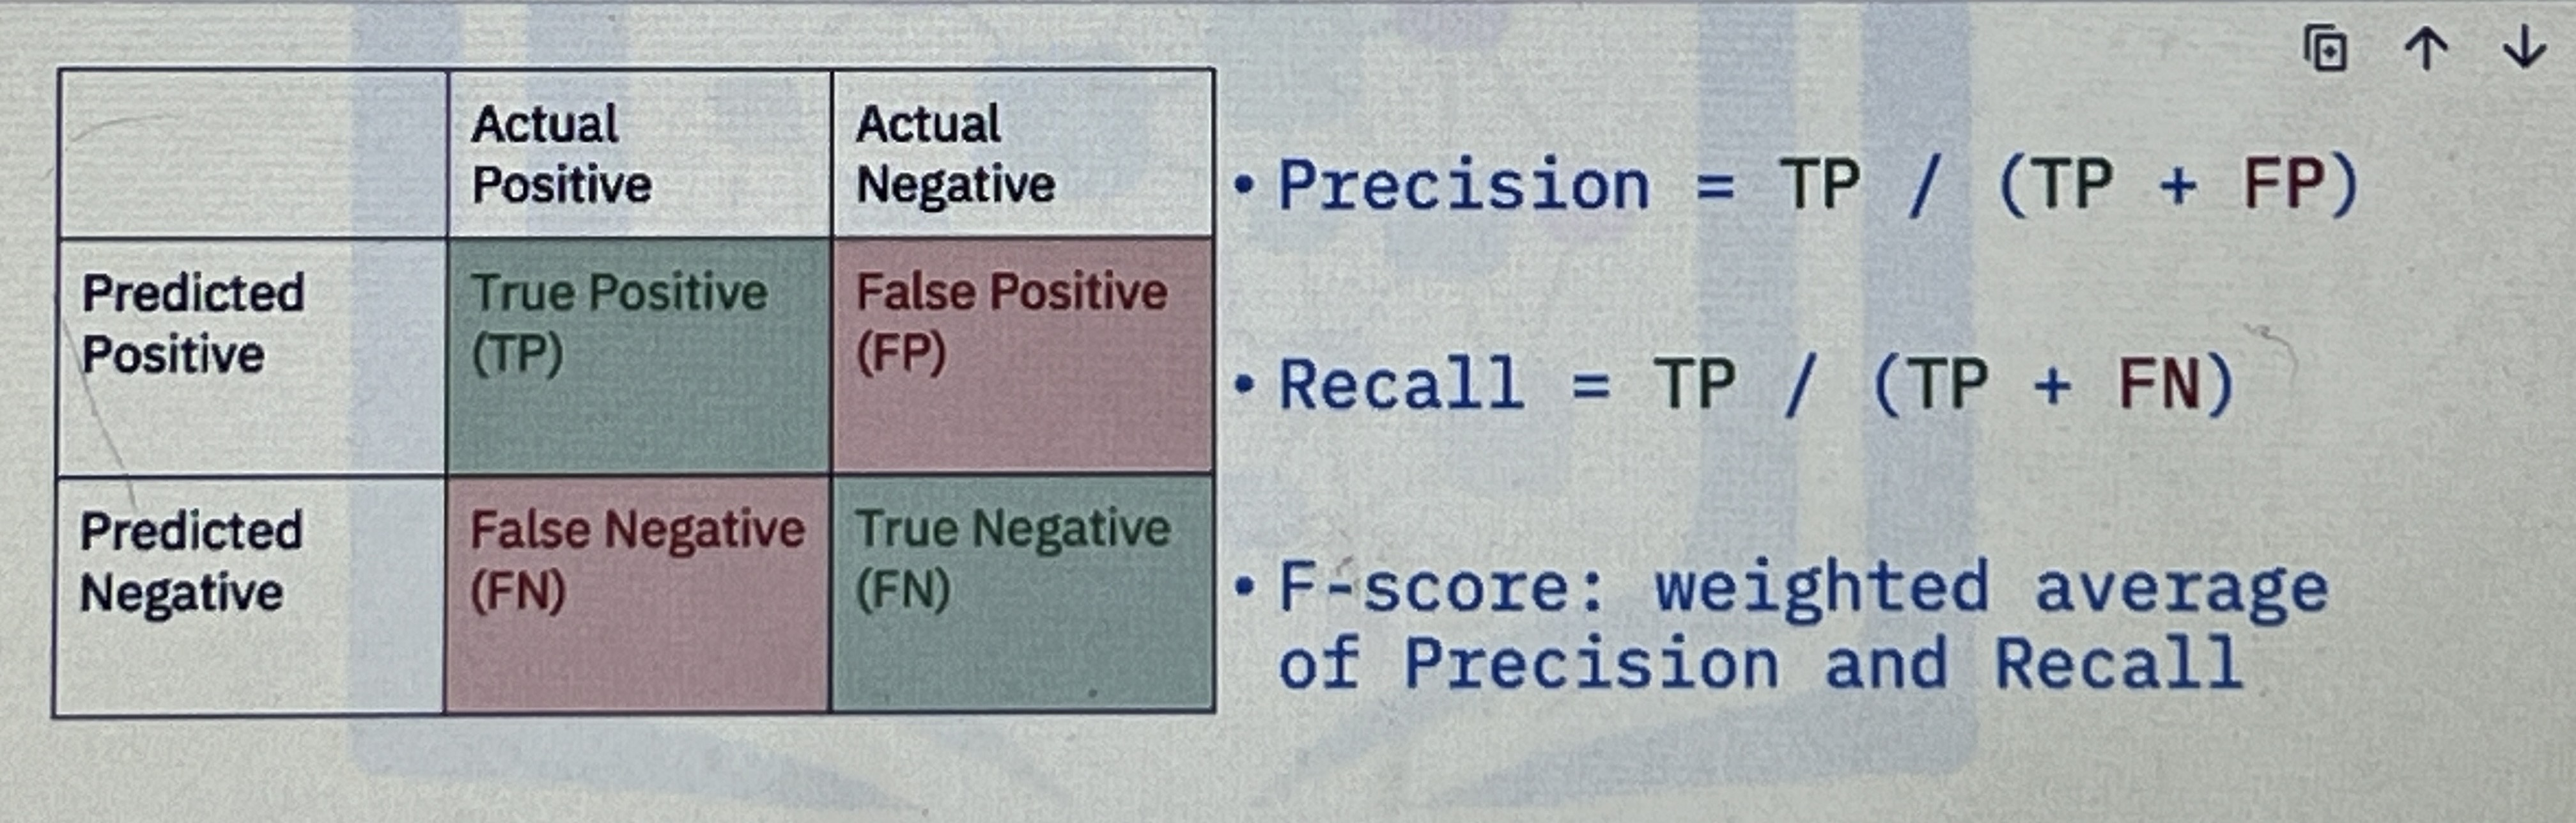

0.9992757242757243

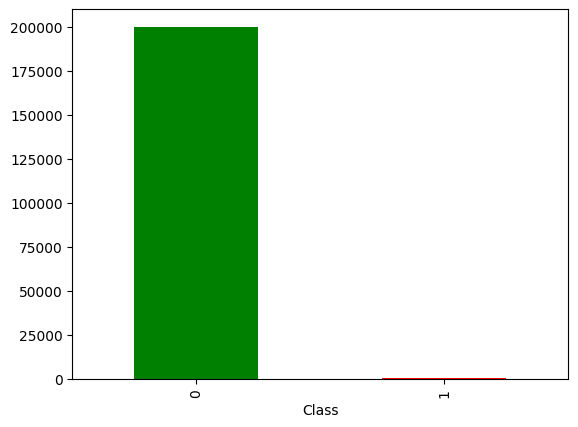

In [20]:
# %%
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0

# install imbalanced-learn package
!pip install imbalanced-learn==0.8.0

# Note: If your environment doesn't support "!mamba install", use "!pip install"
# %%
# First, let's upgrade scikit-learn to a version which should include the _print_elapsed_time function
!pip install --upgrade scikit-learn

# install imbalanced-learn package, as per user request
!pip install imbalanced-learn==0.8.0

# Now that the correct version of scikit-learn is available, we can import the libraries
# %%
## Import packages here
import pandas as pd
import numpy as np

from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from collections import Counter
# %%
from collections import Counter  # Remove "in google collab" from this line

# %%
!pip install imbalanced-learn

# %%
!pip install shap lime
import shap
import lime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score #Added roc_auc_score
# %%
%matplotlib inline

# %%
rs = 123
# Grid search hyperparameters for a logistic regression model
def grid_search_lr(X_train, y_train):
    params_grid = {
    'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}]
    }
    lr_model = LogisticRegression(random_state=rs, max_iter=1000)
    grid_search = GridSearchCV(estimator = lr_model,
                           param_grid = params_grid,
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Grid search hyperparameters for a random forest model
def grid_search_rf(X_train, y_train):
    params_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}]
    }
    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model,
                           param_grid = params_grid,
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params
# %%
def split_data(df):
    X = df.loc[ : , df.columns != 'Class']
    y = df['Class'].astype('int')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)
# %% [markdown]
# Scenario: Credit Card Fraud Detection
# Let's start with a credit card fraud detection scenario. The dataset contains transactions made by credit cards. As you can imagine, the majority of transactions are normal and only a very few real fraud transactions are in the dataset. Our goal is to train a classification model to recognize those fraudulent credit card transactions.
#
# First, we load the dataset as a dataframe:
# %%
credit_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)
# %%
credit_df.head()
# %% [markdown]
# Due to confidentiality issues, the original features and other background information about each transaction is hidden, and this dataset now contains only numerical features which are the result of a PCA transformation.
#
#
#
#
#
#
#
# Next, let's see how imbalanced this dataset is:
# %%
credit_df['Class'].value_counts()
# %%
# Visualize the count for each class
credit_df['Class'].value_counts().plot.bar(color=['green', 'red'])
# %% [markdown]
# As you can see, we only have about 0.001% fraud transactions in the dataset and you can not even see it on the previous bar chart! This is an extremely imbalanced dataset
#
# Next, we will quickly build a standard logistic regression model to see how it performs on such an imbalanced dataset.
# %%
# Split the training and testing dataset
X_train, X_test, y_train, y_test = split_data(credit_df)
# %%
# Build a simple logistic regression model
model = LogisticRegression(random_state=rs,
                              max_iter = 1000)

# Train the model
model.fit(X_train, y_train)
preds = model.predict(X_test)
# %%
accuracy_score(y_test, preds)
# %% [markdown]
# OK, it achieves 99% prediction accuracy on the test dataset, looks like a great model! Before concluding we have found a simple and great model to detect credit card frauds, let's try other metrics first.
#
# More Robust Evaluation Metrics
# Here are some effective robust binary classification evaluation metrics such as Precision, Recall, and Fscore, which can be defined as follows:
#
# Precision: the percentage of accurately predicted positive instances
#
# Recall: the percentage of successfully recognized positive instances
#
# Fscore: can also be called F-beta score, which is a weighted average of precision and recall to evaluate the model. The weights between recall and precision are controlled by the beta parameter, the default value is 1 so the most common F-beta is F1 score
# %% [markdown]
# ![IMG_8159.jpeg](data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAASABIAAD/4QCMRXhpZgAATU0AKgAAAAgABQESAAMAAAABAAEAAAEaAAUAAAABAAAASgEbAAUAAAABAAAAUgEoAAMAAAABAAIAAIdpAAQAAAABAAAAWgAAAAAAAABIAAAAAQAAAEgAAAABAAOgAQADAAAAAf//AACgAgAEAAAAAQAAD76gAwAEAAAAAQAABQcAAAAA/+0AOFBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAAAOEJJTQQlAAAAAAAQ1B2M2Y8AsgTpgAmY7PhCfv/iAihJQ0NfUFJPRklMRQABAQAAAhhhcHBsBAAAAG1udHJSR0IgWFlaIAfmAAEAAQAAAAAAAGFjc3BBUFBMAAAAAEFQUEwAAAAAAAAAAAAAAAAAAAAAAAD21gABAAAAANMtYXBwbOz9o444hUfDbbS9T3raGC8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACmRlc2MAAAD8AAAAMGNwcnQAAAEsAAAAUHd0cHQAAAF8AAAAFHJYWVoAAAGQAAAAFGdYWVoAAAGkAAAAFGJYWVoAAAG4AAAAFHJUUkMAAAHMAAAAIGNoYWQAAAHsAAAALGJUUkMAAAHMAAAAIGdUUkMAAAHMAAAAIG1sdWMAAAAAAAAAAQAAAAxlblVTAAAAFAAAABwARABpAHMAcABsAGEAeQAgAFAAM21sdWMAAAAAAAAAAQAAAAxlblVTAAAANAAAABwAQwBvAHAAeQByAGkAZwBoAHQAIABBAHAAcABsAGUAIABJAG4AYwAuACwAIAAyADAAMgAyWFlaIAAAAAAAAPbVAAEAAAAA0yxYWVogAAAAAAAAg98AAD2/////u1hZWiAAAAAAAABKvwAAsTcAAAq5WFlaIAAAAAAAACg4AAARCwAAyLlwYXJhAAAAAAADAAAAAmZmAADypwAADVkAABPQAAAKW3NmMzIAAAAAAAEMQgAABd7///MmAAAHkwAA/ZD///ui///9owAAA9wAAMBu/8AAEQgFBw++AwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/bAEMAAwMDAwMDBAMDBAYEBAQGCAYGBgYICggICAgICg0KCgoKCgoNDQ0NDQ0NDQ8PDw8PDxISEhISFBQUFBQUFBQUFP/bAEMBAwMDBQUFCQUFCRUODA4VFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFRUVFf/dAAQA/P/aAAwDAQACEQMRAD8A9qPhm877qfF4aumO0hsV3RvSenSopLqUDMfB+lTzk3OXfwdLgH5gT6f/AK6z5vCl/GfkDbfrXdQ6jcgHzST+FTNqErD+mKVwucCvhq48v5s7h2qsnh68LbRuPbqa7l5bliSDx6U+CWUOB3zVXC5xv/CK3xx94fjTh4SvSP4uPevRTcSocZ5pBeS5xnJ6UXEecnwjdfxbh+NV38J3m7Ym7J9zXp0txJGMsc55qibybdvBouBxcPgS6kXLl89uTWZP4L1KJ8Lu29uTXqaX93tBDH2xUBv7ouC7EgdsUuZCueZL4Nv8biXB+tSx+D77PzM+Pqa9WW7ZwMHFQPczZAGfSjmC55rL4XmiwNz5Puaj/wCEZuP7zfma9NmhmkKtmhbe4JABGaSmFzzH/hGLo9C2frVdvDGqA5VWP4mvVzZ3afNkY9qkDS469OvFN1AueWQ+GL4j97u/WrI8NXA4+avTcyGPfzj0qrl8nHHpQqg0zkbPwtA6kXDsH7VFdeFjExWEn2rqvJujMsmcBTVqU3DMCG4xS9oFzzz/AIRa/b7obHtSnwbqLdm6etekxzzRqBmrIvpVQjvjin7UOY8qfwjqCDndgVGfCV4VOwNnHrXqKXUznEhyKniuo4idw5pe1Fc8cbwhrm75UbH1NObwjrCjkPj6mvYDqEufkPy+mKhm1BwCp/lR7ULnkJ8LaoP7/wCZpYfC2rFgGDYPvXp7Xj8EDNH2m5uAY4OHPAPv0q/aBzHBP4Pukj3ktn61mt4Z1EMdu7H1r1NE1G2TF64fvUbzSEfJ0pKqFzzA+F9Q2Fvn3DpzVePw7qzHEoYKPftXqiXMiuC/3RT5ZGnfMPAxVe1C55zH4WmI+Znz9aR/CN+wJi3ED3r0PZcKRz1rQV57dQOxHSnziPIH8J6goz82fTJqAeFtS778fU17MZTJx/FUZSYcnpS5wPIP+EU1Jum786mj8J6r334+tesrIy9qlEkxHy9PTFL2gHlR8K3wHDOSPeo/+EY1L1bj3r1sRT43ZppjuChPaj2gHk58O6kF+TcSO2arHQ9YJClWx04Neuxl1Tpz06VKsTsN+OlHtAPJf+EX1PAb58/Wm/8ACN6p0G7869ajmYvgjAWrDFnYLHwan2okeNSeGtZYAKrce5qA+FNZfgh/zr2/LwLmQ5JHFRq8smWTgCqVULHi0fg/Vh1DY+pq2vhHUMfxD6E16/8A6SeM0kjTQLuc8Hpij2gzyVvCuoIBgvn6mov+EY1v+AMR9a9UaSaWQKh5PtWkHnto8yHj2o9oB5IPDWoonz7w3pmqD6LrCnYQwHbmvYhL9obgVXvQYmXdye3GKamB5ivhHUmtjcHfu+pqsvhu+biQtx7mvZLG7O0Ryfd9Kde2Uk6h7fih1BHjcvhjU0wIdxBHrTE8M6pn5ww/E168BPCAkhyelSjJHPX6UvaCPIv+EY1EAlS2frVFvDutgkAPj6mvagJM9ePpUg4HzYp8yC54rHoesxjo2fQmn/2BqzHdhs9+TXtICf3eKY7RjAUc/ShyKPIf+EfvkXLls+lVG8PavNJtjViv1r277JvAJGQRVgRJap5uBgdqPaiueJDwhqm3kPn0yary+FdYj5VWx9a9re7L/c70jySADdyD6Ue0BI8RHhvUyejZ+tI3h/VAcLuJ9MmvaH+7lBg0y1j/AHhL8/hVKsD1PGDoWqIMncPxNRNpOoY6uPxNe+XFnHJFwB/kVyVxAsEhDAba2jVIaPNF0DVym9N+D3yagOg6l99y3y9smvUW1BUQRx8dhxUEcdxPnng+1dF0Rex5i1nrKLtgDFfXNRDTtW6tuz7GvVvsE4GIyMelUyQGaNh8w6mpuLmPOE0/UCQFZy2emasyafqwGG3Y+pru18pWyow3rV7IjT7ROMxjtVXQXPO7aPV4MhQSPcnpUcy6nMdg3ZPGBmvSN0Mq7olwMVQ8lUkDAcikFzzqTRtd6gPg9OtOTRvEOOEYj6mvV086RRzx6VKL5YBsb7w9BSdgUzyd9P1yAjerCrcNvrWAyhiBXpJzeZbsKdHbuowuMelCK9oeXSnU2byzncO1S/Y9Y8sv82Bz1Nd7cW8Mb7inzGpxBK0RYH5cdPpT0Fc8vOn6vPyC34E0wW2vWxwNxHoSa9Mg5wiDBFT/AGV5SegwKLjuebQafql0paXcAPQ1BJaalbE+WXIHua9MRNmUXoeKtLYxyLllBp6BzHko/t6T5YgxNWk0jxNKCdj/AK16ctlHbtuX8q14LnACjrWUyos8a/sTXFOZQ4/E1ZTRNcADRqxzXskiq/3hz9K0Ukt0iUBeRXO5WLueCzaF4gk6qw9eaWHwzrmOjfnXu4ngmRvLXBUGok8zaWHA9MVPtRnig8P60n8LZHuakOj66oA2tj8a9mVw7YI5qacKF6c0OqCZ4gdD12YFQG59zULeFNexkhwPrXuEDqDjHP0qyfMYHHTHpR7Qg8GTw9rZBjTeT0xk0L4X1uNt7bs/WvdLWPliOCKkeN3fBFHtQPBJtC1+f5NrYHvVQeGfE0bbgj4+tfSCwxRqPl5qU4EbMeQO1L2otT54TSvFGNjRttHv2rOki1qB9p3bgelfRMmJYyYhiuUv7SKNjJKhZj6V00pCZ5Ew8SXGAisVH1ph07X0XzHDgfjXqaSICFiGKtsFMeJeRW2hlqeWRnVkj2gNnGMZqq1h4glbcitgnsTXrEUVq5wq8ir8aIgwlGhfMeNGy8TRjlDt9eahSx1yViVDEjtk17RPIqqUfmqESBH3qvB9qLIFK55ObPxAOJFYL9TQmn6/If3QY+2a9hIjk+VhTkiWE/uwMVIXPIhpXiQc7HyPc0Na+I4x86soAr12SaTgDrU5t/MQeZzkUMLnjaya2q4y2fxoEmut0DZ/GvXVtLMHBjGfWpxYWvVEGaQ76Hj2zxC3OGI+ppksGtTqYsNk+lewtZqp+XAWnrbW+4EL83qBVE3Z4yug+JFUOFfB6c1JHourn/XBgfqa9knuHiUR546YFQbC43HrTC55YNI1mEeYgYge5pjpq/3SGB9MmvUtzb9nb0oeK34JTk1LkNHlCaZrbOGXefbJqebTfEcg8tkbae9euhI4l3AcY7Vr2UazoGcZHpisZVC0eBJo2vKSAHwOnNKNF8TS5CI5/E19Giwg5O0ACshw8cwEQ2jisVUKseE/8I54pjbLo4GPWmPpHiHoVbj3r6GF2gcRTjcfbpUy2sEmX2cVXtR6nzimheJ35jjYge9L/YXibo8bCvo2NFGfKACjtUU6oSePxxQqgz59t/DfiORiFjYn0yauS+EfEcaFnjYcZHNe+W+I+UHPqBTrqWcj5iCo7Ue1JPnD/hHPEUf7xVfcOnNWBaeJEUJsIPTqa97gdJJNpX9Kp6hAFYMgwDT9oNHhR0nxM5ztfPXg0n9k+KR/yzfH1Ne9oilV456VM8JRC7fdFZ84zwmLRvFMoPlo2QMnmnLpniRch1YEds175p4KMzj7rUTRRsxwOvWnzAeErpfiNhhUYmkk0LxFKMSKw/GvdY7Z9+1AAahkl8mikg5FP2grHhEPhDXpQzAOSOnJp7eHfFUKlFjfA9696hncZ8virLecRvJ/Sj2grHzs2heKwBuR8fWhdH8Uo4dY2yuPWvoDezkrjpTThGCnGT0pqoNHgc9r4jL5lRhxjgmmiw8SsBsRiK92uUtlGZV3HrUuntaykoq4A6g0cwzwiO18Q/cVDuPAGT1p0mk+JM5lRgfYmvfJrK3Mim3ADD9KsbrTZ9nuF3TEdhS9oLY+b5NP15jtUNn0yabLoHikLumjZU7c9q94ezhSYuqgDr0q5cFp4Ch6AYFNVBnztDoGutzHuP4mphoviQHAVsCvaooJIfu8AVPAWmlKAYx1zS9oDR4a2meI+yvkfWnx2XiVOisT+Ne/yW0alVA5P5VLHZxKu5loUybnz4dJ8SOdzI/PoTU8OmeJUB2o/wCtfQAS2f5QvSjyIsgJihzEeB/2f4nI+4361C2m+ISfnDg+xNfQYtgH2kDFOmgtYgDKgJ7UKoNHz0ukeJ26I+O3NWU0rxAp/eqwHpk17o6GLleh6YFVpYWkXOOadxnikmi6zL/qAxbuMmqbeHfEmfuNj6mvfoYookDBcNUTeYSeeO3FJzC54auleIYU2lGA+pp66Xrw+YBvzr247cfvF/KjEe3hMUKY0zxF9M8RSDaUbHSoV0jxFEfkVyfqa9xW2kflRgemKckBEm1qfMQeFlNaU7HDBvxq0LHXDg7WwfrXr9xpcBk8zA3etWDZ7U4HA6U1MdzxJ7HWc4YEH2NR/Y9cQfKGP4mva/scbfMVqM6c3UDjtV86KR4ZPBrRIBDDPHU01NM12Y4w2017tFpMUnDrz24psmmmBwqDFHtUB4eNE1wE5DDHTrU8Gj6yT824r35PSvcjZ/ustjNZK2syOf7npS5wPLBDq9rMEg3MBVaf+2d+4gg+xr137JFLcARrtPvVqfTLUIAygt7VVwueJj+3pDtjDE9hzUpg8QpjzUI/E17BHp8MWWUYYdKd9k807pMECjmQHjoj1Uev60gs9ZkPyhiewr2b7DZDG6Pn2o8i3U/u1w3b61omgTPHPsutwttcEH0qH7Nrsjnywx9s17RLDAeZVy/rUlvbW8YLhP0qZVEB4u9l4nTG1Dg+9QPpniV25VsfWvaJ2M2fJHTipraJhETKOahTQjw+ODW4W2IGL+mTVqXS/ETp5kisPTGa9hmtbUEOkfzt3xWnHp88ceLnDK4yB7VdwbPn8f29F+6AY9qeTrm3kEfnXtt1p1qgJ2c+oqqmlJcD5QBWTmgueL7NbPQNk9OTV2HStYmTzDv39hzXq7+HplywwBVq1iSA+XIPmHpQqgM8gOjeIAeFbnjrS/2J4hUZVWOevNe6IsZOMYoliMDAkcH0pOoSeE/2N4jf5SrfnUD+GfETHID4+tfRcEEcieYo/A1WdwXKIMEdaXMikz56bwxr+OQ+QOOalh0nxLENm1yPxr6GbyYF3SrnjtVLyTeSbrYbRVxqCueIjSvERHKuD9acdD15huVWz6Zr3xdPYIN4GRSRwor4wOvNTKYXPn6PR/EEUol2sGHGKfcaXrF5hJgwI98V9Fm1tzjCjNZd9YRQYkCgk+lSpgmeEx6D4gtcGAOQOep7U97XxQQVMbYP1r2vyJ5QPK4Hp0pv2OdeXIK1SmUeByaN4gkJLBxj3oGk+IiQkYYk9Bk19Bx28bjBAyKgaGOOZDGMGjnA8Hbwx4oYfNE4/OnHw34n2Y8tj+dfQ0srRrubmqgujnOODR7Qg8BXw54mB/1bce9IfD3iLdna+R7mvogK8kZZMcVmxLKbna/Sl7UG2eFjRPEy4wj/AJ086V4jTG5HH419BXIjgQccnjpVeSFI08yUbgecUlUA8G+wa8B0bj3q1B/wkkWQiE17hHbW1wnmImBUiWVup+7yKrmA8LMXiYfMEOaz59J128bzJ9yt0AGa+g5FtVIUr7UG2tQvmFc+lK47ngCeEvFAUSLGxQ9CSakbw7rgHIcEe9fQcF4WBhH3QMAYqBtiv8y5z7UnUFzHgdv4d1lZQxD59Mmtabw/rflho1Yn6V7UtrvO5OB6UTpJEg5H0xQqg7ngLabrkJ2ncCeBUi6Lrsx+YMF+te3RpaygvKmStSs1v5eYgMdMVSkFzwFtB1+NyUDFfrTI7XXSCiKSRx3r3F8sDsAxg5+lVbWzBkO1QDmm5CTPHP7M8REco/608aRrzDlWz+Ne3t5cUghcZaqs8iRMPkJ+lJyA8ZGj+I+yMR9acNI8QA/MjY+pr3iNBJCSowcd6x5ZWiba4oUh3PIjomsHk7s+lOGka2v3Vb25r1+KJpuV4pszfZmAcZJochHjknh7XZP3m1t3pmov7E1tBiQOPxr3OMPKm+PAAqOWEIu+bBpc5SPDjouuE/KrEfWnDSNYQ/OGH417bZPBc7ljAypxUd1pk8knyY2+lHtRHkEWj6vcHb82B0wTT5dH1yBCFViCD3r1m2j8l/LxhhWs0S7MuMjuMVp7QR89f2HrjvvQPn6mrEeh+JDwqNkepNe7C3jZC8K4xTQkiglDgj+lT7QDwyTQtbUhZ1YMfc1GfDutj5kDn8TXtUh+0vtYZYcA4UyQva8PjA9BWkZCbPHP7K8SogCxtge/pTRBr6AjDZ6V7VHIZEzjg+1VpLZAc4/CquJSPGm07V5fmfcD6DNXrfTdVbCOXx9TXqDWyngDt6VAP3T4xj0ouK55zdaNqw27A3p3qh/YWr/AHiGz9a9ce44B9KYu+VuOB9KLiueLy6FrLMd+8L25NTQaPrKDCqSPqa9cuGUDYRkj2pkEbuQFxg1I+Y8sk0fXZATtf6ZNNXRNVUZlDg/U17H5i20gSUdKYTFMxOPl+lMVzzO3ttZjQrErEeuTTxZazIeAxPpmvTAqouI8DjpU9vCAfOPI+lJsXMeKXHhzW2lMjbgD6E1F/YesLgDeePU17e6yTuQvCjtipGghjA3AZpKQ7ngzaDrhPyhs9ualg0DXIm34fP1r3DMKjpn8KQsmMqMe1U2Vc8rlttaaMRFCBjBxmqiaVrMZ+QMfxNexwxRyRPkZYdPy4quiiI+W45pNkc55HJpmsk8hh+dRjR9Wb7+8D6mvZTEsgOBziqn2eTdzjbUl855anhvUGG5C2fTNOj0HWkJAVj+Jr1OZZIYfMi4xUdtLO2WbpTFznkc3hzVg2SXGfc0R6BqvQFx+Jr12SdM4cZpFKscqMD6VNx8x5N/wj2qZ+ffg+9XH8I33l7rcuWx616rtdutRjUHHGcn6Vg5l3PNk8GXrMNytj61sweBYmUecTn05rt4b2QuATxVi4uyVAjOCOtZuYHn8/gdEx5JJFR/8ACEnbn5s/Wu8a5lC5B6DkUDUv3Wz+KhTC55w3gyZmIwwHbk1Wn8FXS48oFgK9QS9ZBuc8U833mEeXx7VXtBHkX/CH3x4KkfTNOTwJqMp4RiK9ba72/ePP+fakj1SQcRnAFL2hVzy4+Ar5UyUbge9Uj4VvE+UKQa9fl1tmUoOvQ1RjuwzbG4Y85pxmFjzBfCs7HEwIx6Zqnqfh9rR41tSST2zXrkoZl4Iya5S8imVi7HJHSuuGpk2ctaeHBJGHuiyn2qV/DDv/AKncQK661bzIAH60yO5lilK55ua1sTzHCT+F78fcjyKqHw1fpyQQK9SkvnfaIz9azHuLgXI3H5PSlYaZwH9iXEXLAjNVhotzO37ot9K9OkVJ1/CqETJZzAY6ntQI46PwxfD74YVMfDc44+b869ElvNyfKe1VvtiKPm60AcC3hybHIb86gHh6UnAyK9EUvOcp0pJB5Q3fyouCkedv4buB/ewadH4TnPUMR9

For many machine learning tasks on imbalanced datasets, like this credit card fraud detection, we normally care more about recall than precision. As a baseline, we want the model to be able to find all frauds and we would allow the model to make false-positive errors because the cost of false positives is usually not very high (maybe just costs a false notification email or phone call to confirm with customers). On the other hand, failing to recognize positive examples (such as fraud or a deadly disease) can be life-threatening

As such, our priority is to improve the model's recall, then we will also want to keep precision as high as possible.

Synthetic Minority Oversampling Technique (SMOTE)
SMOTE first creates many pairs or small clusters with two or more similar instances, the measure by instance distance such as Euclidean distance. Then, within the boundary of each pair or cluster, SMOTE uniformly permutes features value, one feature at a time, to populate a collection of similar synthesized instances within each pair or cluster.

As a result, SMOTE creates a class-balanced synthetic dataset without adding duplicated instances with minority labels.

The imblearn package provides us with many effective samplers including SMOTE, RandomOverSampler, and RandomUnderSampler. Let's use its SMOTE class to define a SMOTE sampler first

In [21]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [22]:
# Create a SMOTE sampler
smote_sampler = SMOTE(random_state = rs)

In [23]:
# Resample training data using SMOTE
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


<Axes: xlabel='Class'>

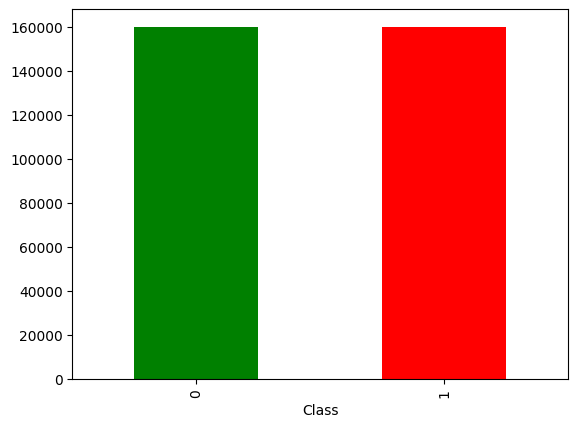

In [24]:
# Visualize classes
y_smo.value_counts().plot.bar(color=['green', 'red'])

In [25]:
# Re-train the model with resampled data
model.fit(X_smo, y_smo)
preds = model.predict(X_test)

In [26]:
# Calculate the precision, recall, f5 given the y_test and predictions
# Note that we use beta=5 which means we think the cost of positive class is 5 times of negative class
# You could try other beta values yourself
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 0.97
Precision is: 0.03
Recall is: 0.88
Fscore is: 0.42
AUC is: 0.92


Next, let's take a look at the recall. The recall is now 0.88, mostly two times larger than the original recall value of 0.45.

However, our model's precision is only 0.03. One possible reason is our dataset was extremely skewed, and oversampling the minority class significantly disrupts the original data distribution so that the model trained on the SMOTE dataset generates large false positives on the test dataset sampled from the original dataset.

As such, for an extremely skewed dataset, we generally do not use oversampling as it significantly shifts the original data distribution.

Next, let's try class re-weighting to see if it can achieve better results than SMOTE in terms of Precision, Recall, and Fscore.

Class reweighting
For binary classification models, its loss function is normally calculated via a sum of the loss with respect to class 0 and the loss with respect to class 1. By default, their class weights are all 1s meaning we treat each class equally important.

However, since the class distribution is skewed in imbalanced datasets and the loss function optimization process will be dominated by the majority class, we want to help the minority class by increasing its class weight in the loss function.

Class weights can be generally calculated via the following three strategies:

Based on their instances portion in the dataset. For example, if positive instances only take 10% of the dataset, we assign its weight to be 0.9 and weight for the majority class to be 0.1
Heuristics or domain knowledge. Misclassification normally has different costs per class, for example, the cost of failure to diagnose a disease is much higher than a false positive diagnose. If we already know such misclassification costs beforehand, we may use them to assign class weights
Hyper-parameter tuning. Standard hyper-parameter tuning methods can be used to find optimized class weights. For example, grid searching from 0.1 to 0.9 for positive class weight to find out which hyperparameter combination generates the best model.
Python sklearn package provides a very convenient way to adjust class weights during model training via providing a class weight argument. Many standard classifiers in sklearn such as LogisticRegression and RandomForestClassifier support class reweighting natively.

Let see an example of class reweighting in LogisticRegression:

First we just need to create a class weights dict object, and since

In [27]:
class_weight = {}

# Assign weight of class 0 to be 0.1
class_weight[0] = 0.1

# Assign weight of class 1 to be 0.9
class_weight[1] = 0.9

In [28]:
# Define a logistic regression with weight
model = LogisticRegression(random_state=rs,
                              max_iter = 1000,
                              class_weight=class_weight)

In [29]:
# Train the model
model.fit(X_train, y_train)
# Make predictions on the test dataset
preds = model.predict(X_test)

In [30]:
# Calculate the precision, recall, f5 given the y_test and predictions
# Note that we use beta=5 which means we think the cost of positive class is 5 times of negative class
# You could try other beta values yourself
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 1.00
Precision is: 0.65
Recall is: 0.82
Fscore is: 0.82
AUC is: 0.91


As you can see, we have much balanced Precision and Recall values. It indicates that, for an extremely imbalanced dataset like credit card fraud detection, often class reweighting is a better strategy than oversampling. Since undersampling will significantly shrink the training dataset, we normally do not use undersampling for an extremely imbalanced dataset.

To summarize the findings from the credit card fraud detection task:

All models have very high accuracy and AUC values but this does not always mean they have good prediction performance, especially for classifying the fraud cases
Classification on an extremly imbalanced dataset is usually a hard task, especially if we want to have both high recall and precision values
SMOTE can achieve high recall but extremely low precision due to the caused disruptions of original data distribution
Class reweighting can achieve a more balanced recall and precision value
Next, let's consolidate your understandings about the imbalanced data challenge with a few more imbalanced classification scenarios.

Some utility model training and evaluation methods
Before we continue with more imbalanced classification scenarios, let's define some utility methods for you to simplify this lab and increase notebook readability. A method to define and train a logistic regression:

In [31]:
rs = 123
# Build a logistic regression model
def build_lr(X_train, y_train, X_test, threshold=0.5, best_params=None):

    model = LogisticRegression(random_state=rs,
                              max_iter = 1000)
    # If best parameters are provided
    if best_params:
        model = LogisticRegression(penalty = 'l2',
                              random_state=rs,
                              max_iter = 1000,
                              class_weight=best_params['class_weight'])
    # Train the model
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

In [32]:
def build_rf(X_train, y_train, X_test, threshold=0.5, best_params=None):

    model = RandomForestClassifier(random_state = rs)
    # If best parameters are provided
    if best_params:
        model = RandomForestClassifier(random_state = rs,
                                   # If bootstrap sampling is used
                                   bootstrap = best_params['bootstrap'],
                                   # Max depth of each tree
                                   max_depth = best_params['max_depth'],
                                   # Class weight parameters
                                   class_weight=best_params['class_weight'],
                                   # Number of trees
                                   n_estimators=best_params['n_estimators'],
                                   # Minimal samples to split
                                   min_samples_split=best_params['min_samples_split'])
    # Train the model
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

In [33]:
rs = 123
def evaluate(yt, yp, eval_type="Original"):
    results_pos = {}
    results_pos['type'] = eval_type
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=5, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    return results_pos

In [34]:
def resample(X_train, y_train):
    # SMOTE sampler (Oversampling)
    smote_sampler = SMOTE(random_state = 123)
    # Undersampling
    under_sampler = RandomUnderSampler(random_state=123)
    # Resampled datasets
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)
    return X_smo, y_smo, X_under, y_under

In [35]:
def visualize_eval_metrics(results):
    df = pd.DataFrame(data=results)
    #table = pd.pivot_table(df, values='type', index=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    #                columns=['type'])
    #df = df.set_index('type').transpose()
    print(df)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(["Original", "Class Weight", "SMOTE", "Undersampling"])
    plt.show()

In [36]:
churn_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_churn.csv", index_col=False)

In [37]:
churn_df.head()

,tenure,MonthlyCharges,TotalCharges,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,...,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,Class
0,27,70.55,1943.90,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
1,69,93.30,6398.05,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,55,59.20,3175.85,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
3,49,59.60,2970.30,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,72,109.55,7887.25,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0


In [38]:
X_train, X_test, y_train, y_test = split_data(churn_df)

<Axes: xlabel='Class'>

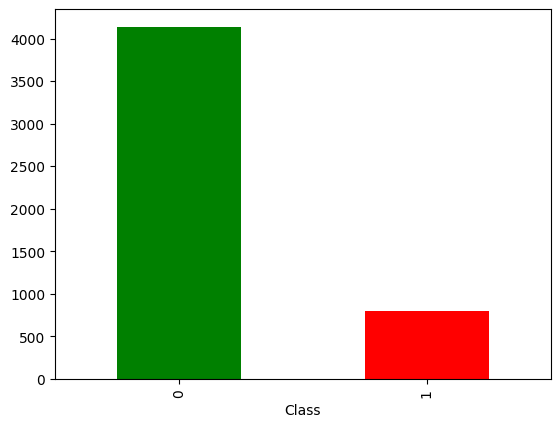

In [39]:
y_train.value_counts().plot.bar(color=['green', 'red'])

As we can see from the bar chart above, the non-churn customers are almost 4 times more than the churn customers, which makes it an imbalanced dataset as well. Since this dataset has 42 features, it would be better to use a more complex classification model and we choose to use RandomForestClassifier from sklearn package.

RandomForestClassifier has many hyperparameters that need to be tuned, we have pre-tuned the main parameters for you. You may also use the provided grid_search_rf() method to play with hyperparameter tuning yourself.

In [40]:
# Tuned random forest parameters
best_params_no_weight = {'bootstrap': True,
                         'class_weight': None,
                         'max_depth': 10,
                         'min_samples_split': 5,
                         'n_estimators': 50}

In [41]:
results = []

Train a regular random forest classifier






Then, we will train a regular random forest classifier without any add-ons (class weights or resampling).




In [42]:
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds, "Original")
print(result)
results.append(result)

{'type': 'Original', 'accuracy': 0.8623481781376519, 'recall': 0.28, 'auc': 0.6274396135265701, 'precision': 0.6829268292682927, 'fscore': 0.2865013774104683}


As you may expect, we have a very high prediction accuracy but even using a random forest classifier, our recall is very low with only 0.28. Next, let's try the class reweighting method to see if we can improve the performance.

Add class re-weighting
We will add class weights to the random forest classifier with pre-tuned weight 0.8 to churn class and weight 0.2 to non-churn class.

In [43]:
class_weight = {}
# 0.2 to Non-churn class
class_weight[0] = 0.2
# 0.8 to Churn class
class_weight[1] = 0.8

Train a regular random forest classifier
Then, we will train a regular random forest classifier without any add-ons (class weights or resampling)

In [44]:
# Pre-tuned hyper parameters
best_params_weight = {'bootstrap': True,
                         'class_weight': class_weight,
                         'max_depth': 10,
                         'min_samples_split': 5,
                         'n_estimators': 50}

In [45]:
# class weight
preds_cw, weight_model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)

In [46]:
result = evaluate(y_test, preds_cw, "Class Weight")
print(result)
results.append(result)

{'type': 'Class Weight', 'accuracy': 0.8137651821862348, 'recall': 0.62, 'auc': 0.7356038647342995, 'precision': 0.4460431654676259, 'fscore': 0.6108374384236454}


As we can see from the evaluation results above, Recall and Fscore are significantly improved by adding class weights. Such improvements indicate that class reweighting is effective for the imbalanced customer churn dataset.

Resampling: SMOTE and Undersampling
Then, we want to use resampling to see if it is also able to improve the model performance.







First, we create resampled training datasets:

In [47]:
# X_smo is resampled from X_train using SMOTE
# y_smo is resampled from y_train using SMOTE
# X_under is resampled from X_train using Undersampling
# y_under is resampled from y_train using Undersampling
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Then we can retrain a random forest classifier using SMOTE resampled input X_smo and output y_smo and evaluate its performance

In [48]:
preds_smo, smo_model = build_rf(X_smo, y_smo, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds_smo, "SMOTE")
print(result)
results.append(result)

{'type': 'SMOTE', 'accuracy': 0.8340080971659919, 'recall': 0.505, 'auc': 0.7012922705314009, 'precision': 0.48792270531400966, 'fscore': 0.504321106203188}


and we can retrain a random forest classifier using the undersampled input X_under and output y_under and evaluate its performance

In [49]:
preds_under, under_model = build_rf(X_under, y_under, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds_under, "Undersampling")
print(result)
results.append(result)

{'type': 'Undersampling', 'accuracy': 0.7336032388663968, 'recall': 0.79, 'auc': 0.7563526570048309, 'precision': 0.3550561797752809, 'fscore': 0.7544536271808999}


Compare the performance among different random forest models
By now, we have built four different random forest models: the model trained with the original dataset, the model with class weights, the model trained with SMOTE dataset, and the model trained with undersampling.

To better analyze and compare their performance, we can visualize the metrics using a grouped bar chart.

[ ]:

visualize_eval_metrics(results)
Let's first see what each color means. The grey bars represent the original model, the orange bars represent the model with class weight, the dark blue bars represent model trained with SMOTE, and the light blue bars represent the model trained with undersampling.

As we can infer the following insights from the bar charts:

All models have high accuracy
Recall is improved with class weights and resampling methods, and undersampling produces the highest recall
AUC is also improved with class weights and resampling methods, and undersampling produces the highest AUC again
Precisions are decreased with class weights and resampling methods as they all introduced many false positives (which are expected as we are trying to increase the impact of the positive class)
Fscore is improved with class weights and resampling method, and undersampling has the highest Fscore
By analyzing the bar chart above, we can see that undersampling seems to be the best method to help alleviate the imbalanced challenge in the customer churn dataset. Although all class weights, SMOTE, and undersampling decreased the precision (increased false positives) but sometimes it is not a bad idea to assume some of your customers are about to leave (even if they are not) as motivation to improve your services.

Scenario: Tumor Type Estimation
Finally, let's see an interesting imbalanced dataset that has very high Precision, Recall, and F-score initially without using class reweighting and resampling.







This dataset contains tumor samples and we need to estimate/predict if a tumor sample is cancerous or not.

First, like other scenarios, let's load and split the dataset

            type  accuracy  recall       auc  precision    fscore
0       Original  0.862348   0.280  0.627440   0.682927  0.286501
1   Class Weight  0.813765   0.620  0.735604   0.446043  0.610837
2          SMOTE  0.834008   0.505  0.701292   0.487923  0.504321
3  Undersampling  0.733603   0.790  0.756353   0.355056  0.754454


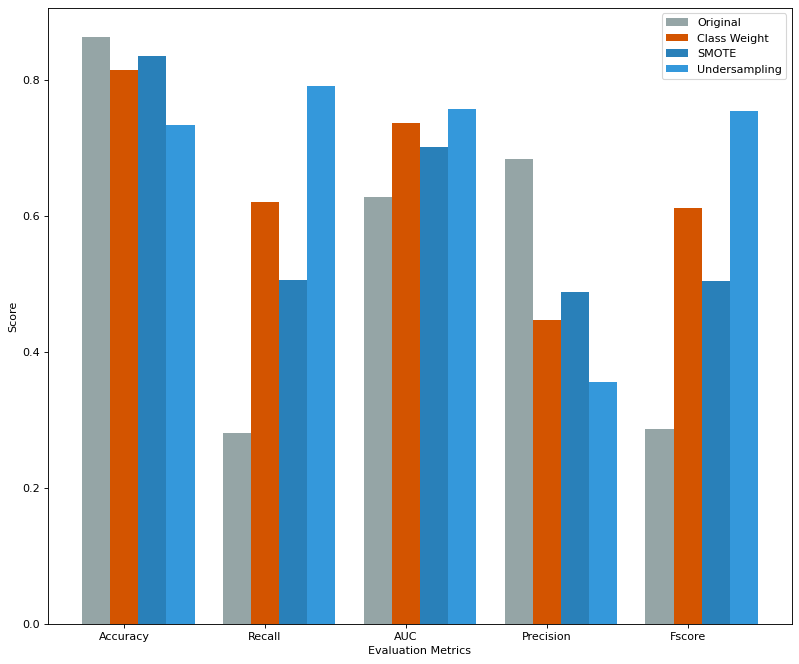

In [50]:
visualize_eval_metrics(results)

In [51]:
tumor_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_cancer.csv", index_col=False)
X_train, X_test, y_train, y_test = split_data(tumor_df)

<Axes: xlabel='Class'>

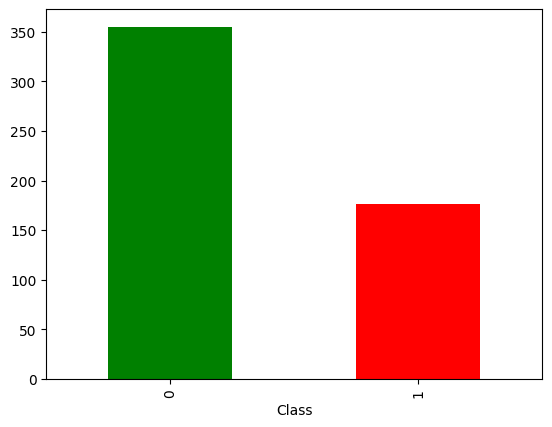

In [52]:
y_train.value_counts().plot.bar(color=['green', 'red'])

In [53]:
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [55]:
best_params_weight = {'bootstrap': True,
                         'class_weight': {0: 0.2, 1: 0.8},
                         'max_depth': 10,
                         'min_samples_split': 5,
                         'n_estimators': 50}

In [56]:
# no class-weights
results=[]
preds, model = build_rf(X_train, y_train, X_test)
results.append(evaluate(y_test, preds))
# class weight
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)
results.append(evaluate(y_test, preds))
# Resampling
preds, model = build_rf(X_smo, y_smo, X_test)
results.append(evaluate(y_test, preds))
preds, model = build_rf(X_under, y_under, X_test)
results.append(evaluate(y_test, preds))

       type  accuracy  recall       auc  precision    fscore
0  Original  0.984962     1.0  0.988764   0.956522  0.998255
1  Original  0.992481     1.0  0.994382   0.977778  0.999127
2  Original  0.992481     1.0  0.994382   0.977778  0.999127
3  Original  0.984962     1.0  0.988764   0.956522  0.998255


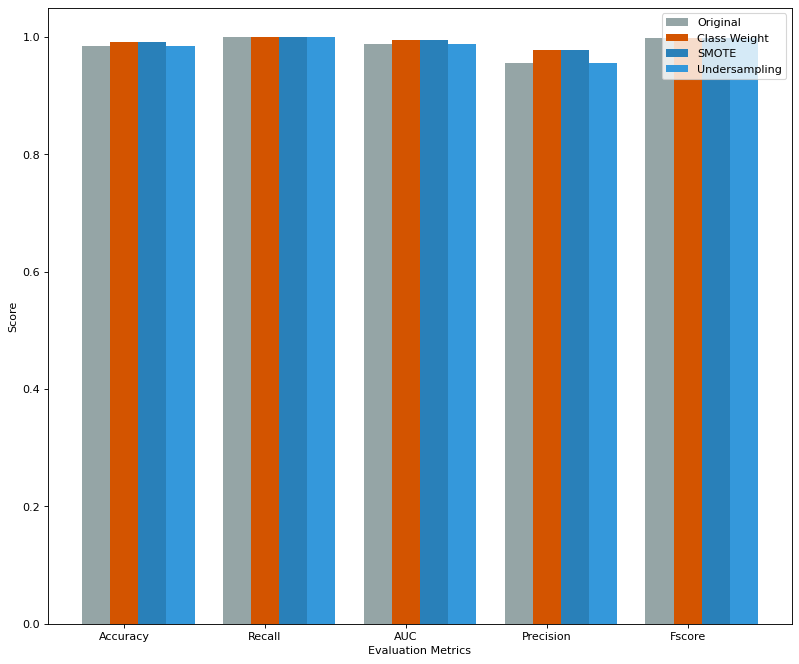

In [57]:
visualize_eval_metrics(results)

As we can see, all grey bars (the original model) for Accuracy, Recall, AUC, Precision, and F-score have very high values and adding class reweighting and resampling does not help improve performance that much. This is possible that the tumor patterns in this dataset are obvious and can be easily picked up by the standard random forest model or the dataset is not very imbalanced and can be considered as an ordinary binary classification task.

Exercise: Predicting Job Change
Now it is time to apply what you have learned in this lab. We have an imbalanced HR dataset and we want to use it to build a classification model to predict if an employee is looking for a new job or not.

In [58]:
# Load the dataset
hr_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_hr.csv", index_col=False)

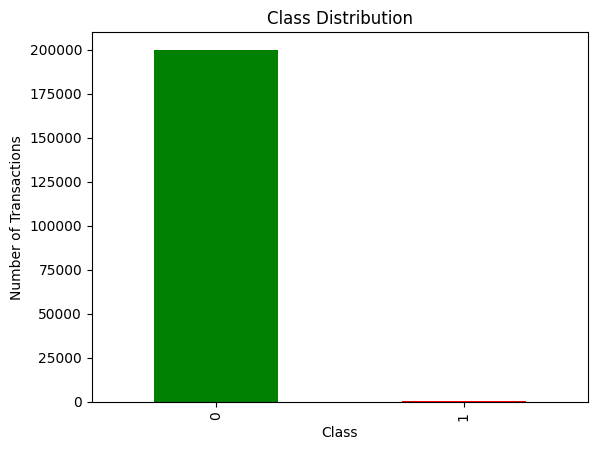

Class Distribution:
Class
0    200000
1       200
Name: count, dtype: int64


In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataframe
credit_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)

# Check the class distribution
class_distribution = credit_df['Class'].value_counts()

# Visualize the class distribution
class_distribution.plot.bar(color=['green', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Transactions')
plt.show()

# Print the class distribution in numbers
print("Class Distribution:")
print(class_distribution)

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataframe
credit_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)

rs = 123 #random state

# Define the split_data function
def split_data(df):
    """
    Splits the input DataFrame into training and testing sets.

    Args:
        df: The input DataFrame containing the features and the target variable ('Class').

    Returns:
        A tuple containing:
            - X_train: Features for the training set.
            - X_test: Features for the testing set.
            - y_train: Target variable for the training set.
            - y_test: Target variable for the testing set.
    """
    X = df.loc[:, df.columns != 'Class']  # Features (all columns except 'Class')
    y = df['Class'].astype('int')  # Target variable ('Class')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)

# Split the data
X_train, X_test, y_train, y_test = split_data(credit_df)

# Print the shapes of the resulting sets to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (160160, 5)
X_test shape: (40040, 5)
y_train shape: (160160,)
y_test shape: (40040,)


In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the dataframe
credit_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)

rs = 123

# Define the split_data function
def split_data(df):
    """
    Splits the input DataFrame into training and testing sets.

    Args:
        df: The input DataFrame containing the features and the target variable ('Class').

    Returns:
        A tuple containing:
            - X_train: Features for the training set.
            - X_test: Features for the testing set.
            - y_train: Target variable for the training set.
            - y_test: Target variable for the testing set.
    """
    X = df.loc[:, df.columns != 'Class']  # Features (all columns except 'Class')
    y = df['Class'].astype('int')  # Target variable ('Class')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)

# Split the data
X_train, X_test, y_train, y_test = split_data(credit_df)

# Build a simple logistic regression model
model = LogisticRegression(random_state=rs, max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
preds = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy of the logistic regression model: {accuracy:.4f}")

Accuracy of the logistic regression model: 0.9993


In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the dataframe
credit_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)

rs = 123

# Define the split_data function
def split_data(df):
    """
    Splits the input DataFrame into training and testing sets.

    Args:
        df: The input DataFrame containing the features and the target variable ('Class').

    Returns:
        A tuple containing:
            - X_train: Features for the training set.
            - X_test: Features for the testing set.
            - y_train: Target variable for the training set.
            - y_test: Target variable for the testing set.
    """
    X = df.loc[:, df.columns != 'Class']  # Features (all columns except 'Class')
    y = df['Class'].astype('int')  # Target variable ('Class')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)

# Split the data
X_train, X_test, y_train, y_test = split_data(credit_df)

# Build a logistic regression model with class weights
# Determine the class distribution
class_counts = credit_df['Class'].value_counts()
# Calculate the weight for each class
weight_for_0 = class_counts[1] / len(credit_df)
weight_for_1 = class_counts[0] / len(credit_df)

class_weight = {0: weight_for_0, 1: weight_for_1}

model = LogisticRegression(random_state=rs, max_iter=1000, class_weight=class_weight)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
preds = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy of the logistic regression model with class weights: {accuracy:.4f}")

Accuracy of the logistic regression model with class weights: 0.9752


In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

# Load the dataframe
credit_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)

rs = 123

# Define the split_data function
def split_data(df):
    """
    Splits the input DataFrame into training and testing sets.

    Args:
        df: The input DataFrame containing the features and the target variable ('Class').

    Returns:
        A tuple containing:
            - X_train: Features for the training set.
            - X_test: Features for the testing set.
            - y_train: Target variable for the training set.
            - y_test: Target variable for the testing set.
    """
    X = df.loc[:, df.columns != 'Class']  # Features (all columns except 'Class')
    y = df['Class'].astype('int')  # Target variable ('Class')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)

# Split the data
X_train, X_test, y_train, y_test = split_data(credit_df)

# Apply SMOTE to the training data
smote = SMOTE(random_state=rs)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Build a logistic regression model with class weights
# Determine the class distribution
class_counts = credit_df['Class'].value_counts()
# Calculate the weight for each class
weight_for_0 = class_counts[1] / len(credit_df)
weight_for_1 = class_counts[0] / len(credit_df)

class_weight = {0: weight_for_0, 1: weight_for_1}

# Build a logistic regression model
model = LogisticRegression(random_state=rs, max_iter=1000, class_weight=class_weight)

# Train the model on the SMOTE-resampled data
model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
preds = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy of the logistic regression model with SMOTE and class weights: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Accuracy of the logistic regression model with SMOTE and class weights: 0.1599


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


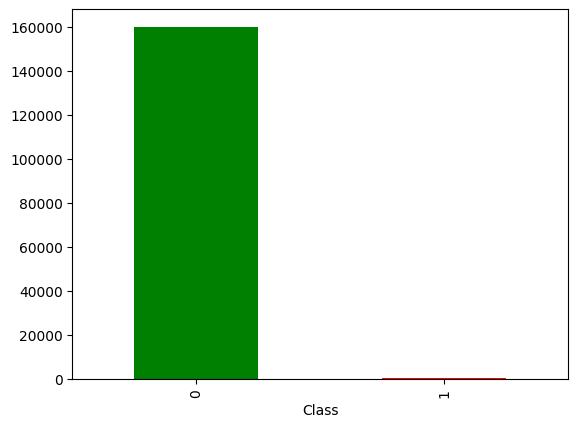

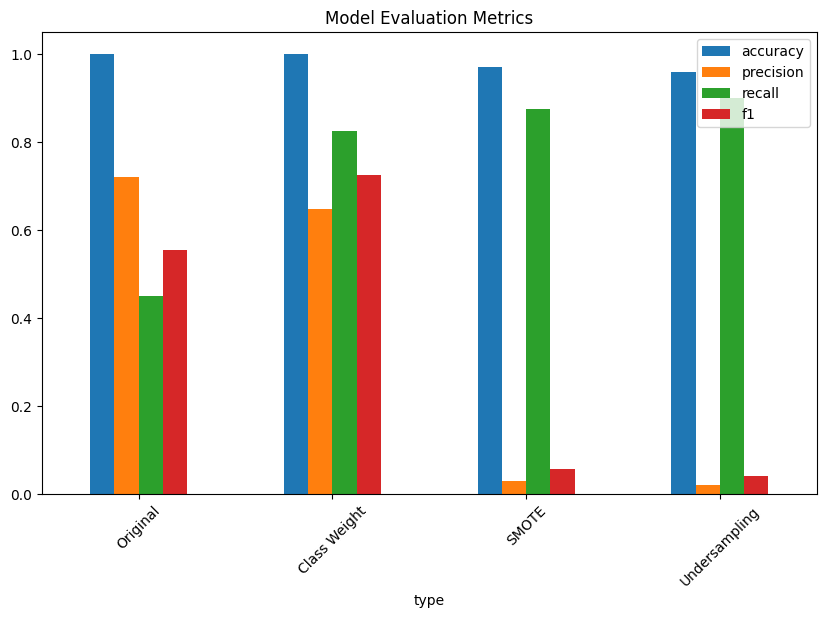

In [65]:
!pip install imbalanced-learn scikit-learn

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

# Load the dataframe
credit_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)

rs = 123

# Define the split_data function
def split_data(df):
    """
    Splits the input DataFrame into training and testing sets.

    Args:
        df: The input DataFrame containing the features and the target variable ('Class').

    Returns:
        A tuple containing:
            - X_train: Features for the training set.
            - X_test: Features for the testing set.
            - y_train: Target variable for the training set.
            - y_test: Target variable for the testing set.
    """
    X = df.loc[:, df.columns != 'Class']  # Features (all columns except 'Class')
    y = df['Class'].astype('int')  # Target variable ('Class')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)

# Split the data
X_train, X_test, y_train, y_test = split_data(credit_df)

# Create the SMOTE resampled data
smote = SMOTE(random_state=rs)
X_smo, y_smo = smote.fit_resample(X_train, y_train)

# Create Undersampled data
rus = RandomUnderSampler(random_state=rs)
X_under, y_under = rus.fit_resample(X_train, y_train)

# Define build_lr with the ability to pass in hyperparameters
def build_lr(X_train, y_train, X_test, threshold=0.5, best_params=None):
    """
    Builds and trains a Logistic Regression model.

    Args:
        X_train: Training features.
        y_train: Training labels.
        X_test: Testing features.
        threshold: threshold for predictions
        best_params: Parameters for class_weights

    Returns:
        Predicted labels and the trained model.
    """
    if best_params:
        model = LogisticRegression(random_state=rs, max_iter=1000, **best_params) # Apply best_params
    else:
        model = LogisticRegression(random_state=rs, max_iter=1000)
    model.fit(X_train, y_train)
    # If predicted probability is larger than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba[:, 1] >= threshold).astype('int')
    return yp, model

# Define evaluate for consistent evaluations
def evaluate(y_test, preds, eval_type="Original"):
  """
  Evaluates model predictions.
  Args:
    y_test: Ground truth labels.
    preds: Model predictions.
    eval_type: Type of evaluation.

  Returns:
    Dictionary with evaluation metrics.
  """
  accuracy = accuracy_score(y_test, preds)
  precision = precision_score(y_test, preds)
  recall = recall_score(y_test, preds)
  f1 = f1_score(y_test, preds)
  return {
      "type": eval_type,
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1,
  }

def visualize_eval_metrics(results):
    """
    Visualizes evaluation metrics in a bar plot.
    Args:
      results: List of result dictionaries.
    """
    df = pd.DataFrame(results)
    df.set_index("type", inplace=True)
    df.plot(kind="bar", figsize=(10, 6))
    plt.xticks(rotation=45)
    plt.title("Model Evaluation Metrics")
    plt.show()

# The code in ipython-input-64-3447053da76f (edited)
y_train.value_counts().plot.bar(color=['green', 'red'])
best_params = {'class_weight': {0: 0.1, 1: 0.9}}
results = []
# no class-weights
preds, model = build_lr(X_train, y_train, X_test)
result = evaluate(y_test, preds)
results.append(result)
# class weight
preds, weight_model = build_lr(X_train, y_train, X_test, best_params=best_params)
result = evaluate(y_test, preds, eval_type="Class Weight")
results.append(result)
# Resampling
preds, smote_model = build_lr(X_smo, y_smo, X_test) #X_smo and X_test have the same column names
result = evaluate(y_test, preds, eval_type="SMOTE")
results.append(result)
preds_under, under_model = build_lr(X_under, y_under, X_test) #X_under and X_test have the same column names
result = evaluate(y_test, preds_under, eval_type="Undersampling")
#metrics.plot_roc_curve(smote_model, X_test, y_test)
results.append(result)
visualize_eval_metrics(results)